# CRM Data Cleaning & Exploratory Analysis (Demo)

This notebook demonstrates a simplified data cleaning and analysis workflow using synthetic CRM and transaction data, mirroring the steps used in internship work.  
All data is synthetic and used for demonstration only.

## 1. Setup & Data Loading

In this section, we load CRM-style data from multiple CSV files (customers, orders, sales employees, senders, receivers).
These files represent tables extracted from a relational database.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

customers = pd.read_csv("crm_demo_data/customers.csv")
orders = pd.read_csv("crm_demo_data/orders.csv")
sales_employees = pd.read_csv("crm_demo_data/sales_employees.csv")
senders = pd.read_csv("crm_demo_data/senders.csv")
receivers = pd.read_csv("crm_demo_data/receivers.csv")

## 2. Initial Data Overview

We perform a quick overview of the datasets to understand structure, columns, and potential data issues.

In [8]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           550 non-null    int64  
 1   customer_id        550 non-null    int64  
 2   sender_id          550 non-null    int64  
 3   receiver_id        550 non-null    int64  
 4   sales_employee_id  550 non-null    int64  
 5   from_currency      540 non-null    object 
 6   to_currency        550 non-null    object 
 7   from_amount        538 non-null    float64
 8   fx_rate            550 non-null    float64
 9   purpose            550 non-null    object 
 10  status             542 non-null    object 
 11  created_at         550 non-null    object 
 12  to_amount          550 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 56.0+ KB


,order_id,customer_id,sender_id,receiver_id,sales_employee_id,from_currency,to_currency,from_amount,fx_rate,purpose,status,created_at,to_amount
0,500001,10009,30155,30004,2001,CNY,AUD,1257.21,0.4366,Business payment,Completed,2026-01-06,548.90
1,500002,10117,30046,30141,2003,CNY,AUD,2523.47,0.6389,Family support,Completed,2025-11-22,1612.24
2,500003,10080,30006,30092,2003,USD,AUD,1406.02,1.0435,Family support,Completed,2025-12-10,1467.18
3,500004,10075,30003,30112,2001,USD,AUD,1261.55,0.5318,Living expenses,Pending,2025-11-07,670.89
4,500005,10019,30075,30094,2008,USD,AUD,2287.67,0.8780,Rent payment,Completed,2026-01-15,2008.57


## 3. Data Cleaning & Standardisation

This section focuses on cleaning common issues such as missing values, inconsistent formats, and incorrect data types.

In [10]:
orders["created_at"] = pd.to_datetime(orders["created_at"])

In [12]:
orders_clean = orders.dropna(
    subset=["from_currency", "to_currency", "from_amount", "fx_rate"]
).copy()

In [14]:
orders_clean["status"] = orders_clean["status"].fillna("Unknown")

In [16]:
orders.shape, orders_clean.shape

((550, 13), (528, 13))

## 4. Feature Creation & Transformations

We create new columns that make analysis easier, such as currency pairs, transaction month, and derived amounts.

In [19]:
# Create currency pair
orders_clean["fx_pair"] = (
    orders_clean["from_currency"] + "->" + orders_clean["to_currency"]
)

# Extract month for time-based analysis
orders_clean["month"] = orders_clean["created_at"].dt.to_period("M").astype(str)


In [21]:
orders_clean[["fx_pair", "month"]].head()

,fx_pair,month
0,CNY->AUD,2026-01
1,CNY->AUD,2025-11
2,USD->AUD,2025-12
3,USD->AUD,2025-11
4,USD->AUD,2026-01


## 5. Data Integration (Joining Tables)

We join transaction data with customer and sales employee data to create a combined dataset for analysis.


In [27]:
df = orders_clean.merge(
    customers,
    on="customer_id",
    how="left"
)

print(df.shape)
df.head()

(528, 24)


,order_id,customer_id,sender_id,receiver_id,sales_employee_id,from_currency,to_currency,from_amount,fx_rate,purpose,...,month,first_name,last_name,nationality,residency_country,postcode,address,phone,email,created_at_y
0,500001,10009,30155,30004,2001,CNY,AUD,1257.21,0.4366,Business payment,...,2026-01,Sophie,Lin,AU,Hong Kong,NaN,"125 Elizabeth St, Chatswood NSW",472720429,sophie.lin2@icloud.com,2025-10-07
1,500002,10117,30046,30141,2003,CNY,AUD,2523.47,0.6389,Family support,...,2025-11,Chris,Liu,NZ,Hong Kong,2007.0,"183 Elizabeth St, Chatswood NSW",479747566,chris.liu24@gmail.com,2025-12-29
2,500003,10080,30006,30092,2003,USD,AUD,1406.02,1.0435,Family support,...,2025-12,Ethan,Zhao,SG,China,2007.0,"1 Anzac Pde, Burwood NSW",405717279,ethan.zhao76@outlook.com,2025-12-24
3,500004,10075,30003,30112,2001,USD,AUD,1261.55,0.5318,Living expenses,...,2025-11,Emily,Zhao,CN,Australia,2060.0,"115 Pitt St, Chatswood NSW",434556405,emily.zhao30@icloud.com,2025-11-28
4,500005,10019,30075,30094,2008,USD,AUD,2287.67,0.8780,Rent payment,...,2026-01,Allen,Huang,AU,Hong Kong,NaN,"37 Victoria Rd, Hurstville NSW",437504310,allen.huang24@icloud.com,2025-11-04


In [29]:
df = df.merge(
    sales_employees,
    on="sales_employee_id",
    how="left"
)
df.columns

Index(['order_id', 'customer_id', 'sender_id', 'receiver_id',
       'sales_employee_id', 'from_currency', 'to_currency', 'from_amount',
       'fx_rate', 'purpose', 'status', 'created_at_x', 'to_amount', 'fx_pair',
       'month', 'first_name', 'last_name', 'nationality', 'residency_country',
       'postcode', 'address', 'phone', 'email', 'created_at_y',
       'sales_employee_name'],
      dtype='object')

## 6. Exploratory Data Analysis (EDA)

In this section, we explore transaction patterns using summary statistics and simple visualisations.


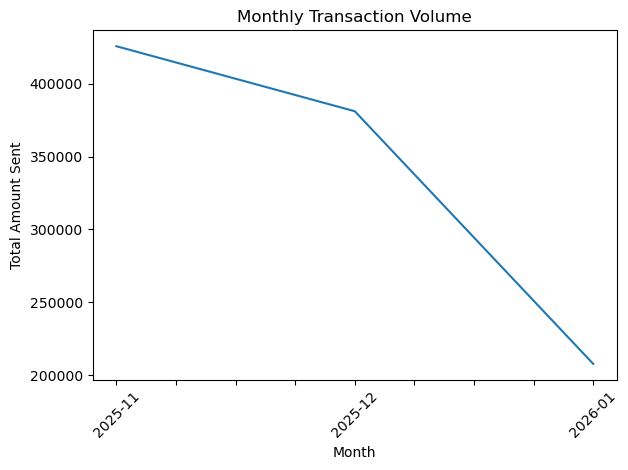

In [31]:
monthly_volume = (
    df.groupby("month")["from_amount"]
    .sum()
    .sort_index()
)

monthly_volume.plot(kind="line", title="Monthly Transaction Volume")
plt.xlabel("Month")
plt.ylabel("Total Amount Sent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


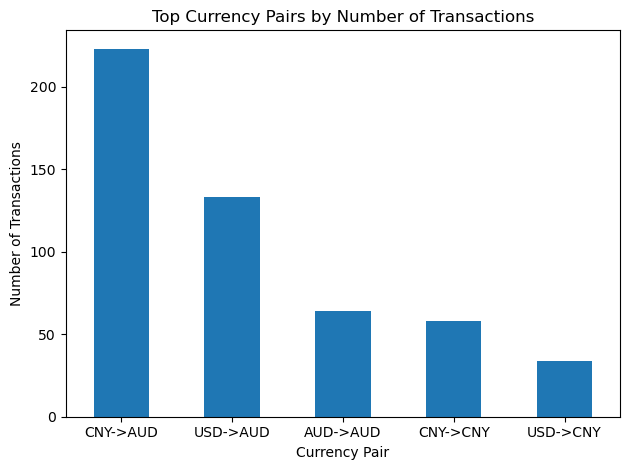

In [33]:
pair_counts = df["fx_pair"].value_counts().head(5)

pair_counts.plot(kind="bar", title="Top Currency Pairs by Number of Transactions")
plt.xlabel("Currency Pair")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


These visualisations highlight transaction trends and common FX usage patterns.


## 7. Export Cleaned Dataset

The final cleaned dataset is exported for reporting or further analysis.

In [35]:
df.to_csv("cleaned_transactions.csv", index=False)

## 8. Summary

This notebook demonstrates a basic end-to-end workflow for cleaning and analysing CRM-style transaction data using Python. 
Using synthetic data, I loaded multiple tables, handled missing values, created standardised features, joined related datasets, and explored transaction patterns using simple visualisations. 
The workflow mirrors typical SQL-to-Python analysis steps used in data operations and analytics roles.
